In [1]:
import pandas as pd
import os
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load embeddings file

# input the path to your saved embeddings
path = '/Users/ellenbowen/Desktop/Michigan/Siwo_lab/'
file = str(path) + 'phecode_gpt_embedding.pkl'

df = pd.read_pickle(file)

In [3]:
# Ensure df is the cleaned version without NaN in 'category'
df_cleaned = df.dropna(subset=['category'])
unique_categories = df_cleaned['category'].unique()
categories = unique_categories

In [4]:
df

,phecode,phenotype,phecode_exclude_range,sex,rollup,leaf,category_number,category,embeddings
0,8.00,Intestinal infection,001-009.99,NaN,1,0,1,infectious diseases,"[0.0068802302703261375, 0.0005461262771859765,..."
1,8.50,Bacterial enteritis,001-009.99,Both,1,0,1,infectious diseases,"[-0.010700925253331661, 1.566567698318977e-05,..."
2,8.51,Intestinal e.coli,001-009.99,Both,1,1,1,infectious diseases,"[0.01900758408010006, -0.0076250554993748665, ..."
3,8.52,Intestinal infection due to C. difficile,001-009.99,Both,1,1,1,infectious diseases,"[0.013732682913541794, -0.013513063080608845, ..."
4,8.60,Viral Enteritis,001-009.99,Both,1,1,1,infectious diseases,"[-0.01282576099038124, -0.0019294519443064928,..."
...,...,...,...,...,...,...,...,...,...
1861,994.00,Sepsis and SIRS,994-994.99,NaN,1,0,18,injuries & poisonings,"[-0.009411283768713474, -0.011322950012981892,..."
1862,994.10,Systemic inflammatory response syndrome (SIRS),994-994.99,Both,1,1,18,injuries & poisonings,"[-0.036918796598911285, -0.012674717232584953,..."
1863,994.20,Sepsis,994-994.99,Both,1,0,18,injuries & poisonings,"[0.004166525788605213, -0.005852119065821171, ..."
1864,994.21,Septic shock,994-994.99,Both,1,1,18,injuries & poisonings,"[-0.012952380813658237, 0.0007000957266427577,..."


In [5]:
# Convert "embeddings" column from string to list of floats
embeddings = np.array(df['embeddings'].tolist())
embeddings

array([[ 6.88023027e-03,  5.46126277e-04,  1.82447825e-02, ...,
        -3.36964726e-02, -1.35426512e-02, -7.85396900e-03],
       [-1.07009253e-02,  1.56656770e-05,  9.50688589e-03, ...,
        -3.81054170e-02, -3.87738179e-03, -2.28424836e-02],
       [ 1.90075841e-02, -7.62505550e-03,  6.57213712e-03, ...,
        -2.29302198e-02, -1.26694283e-02, -1.77550931e-02],
       ...,
       [ 4.16652579e-03, -5.85211907e-03,  9.43277869e-03, ...,
        -1.60769634e-02, -9.92372818e-03, -1.62864346e-02],
       [-1.29523808e-02,  7.00095727e-04,  2.05936357e-02, ...,
        -2.13486478e-02, -1.17743006e-02, -1.21452985e-02],
       [-9.11512692e-03,  7.73080438e-03,  3.55242491e-02, ...,
        -4.11952892e-03, -1.18536770e-03, -1.05863875e-02]])

In [6]:


# Initialize UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# specifications of other paper

#umap_model = umap.UMAP(n_neighbors=50, min_dist=0.4, n_components=2, random_state=42)

# Fit and transform the embeddings
umap_result = umap_model.fit_transform(embeddings)

# Convert UMAP results into a DataFrame
umap_df = pd.DataFrame(umap_result, columns=['UMAP_1', 'UMAP_2'])

# Add the UMAP results to the original DataFrame
df['UMAP_1'] = umap_df['UMAP_1']
df['UMAP_2'] = umap_df['UMAP_2']

# Save or view the updated DataFrame
print(df.head())


   phecode                                 phenotype phecode_exclude_range  \
0     8.00                      Intestinal infection            001-009.99   
1     8.50                       Bacterial enteritis            001-009.99   
2     8.51                         Intestinal e.coli            001-009.99   
3     8.52  Intestinal infection due to C. difficile            001-009.99   
4     8.60                           Viral Enteritis            001-009.99   

    sex  rollup  leaf  category_number             category  \
0   NaN       1     0                1  infectious diseases   
1  Both       1     0                1  infectious diseases   
2  Both       1     1                1  infectious diseases   
3  Both       1     1                1  infectious diseases   
4  Both       1     1                1  infectious diseases   

                                          embeddings     UMAP_1    UMAP_2  
0  [0.0068802302703261375, 0.0005461262771859765,...  11.682556  2.764739  


In [13]:
#save embeddings
df.to_pickle('UMAP_embeddings.pkl')

In [7]:
import pandas as pd
import plotly.express as px
from dash import dcc, html, Input, Output, Dash

# Assuming your DataFrame `df` already contains 'UMAP_1', 'UMAP_2', 'phenotype', and 'category'

# Initialize Dash app
app = Dash(__name__)

# Store clicked phenotypes
selected_phenotypes = set()

# Create a function to generate the UMAP plot
def create_umap_plot(selected_phenotypes=None):
    # Ensure selected_phenotypes is not None
    selected_phenotypes = selected_phenotypes or set()
    
    # Add a column to highlight selected phenotypes
    df['selected'] = df['phenotype'].apply(lambda x: x in selected_phenotypes)
    
    # Create the scatter plot
    fig = px.scatter(
        df,
        x='UMAP_1',
        y='UMAP_2',
        color='category',
        hover_data={'phenotype': True},  # Only show phenotype on hover
        opacity=0.8,
        title="Interactive UMAP Visualization with Search and Click",
    )
    
 
    # Simplify hover to show only the phenotype name
    fig.for_each_trace(lambda trace: trace.update(
        hovertemplate="%{customdata[0]}"  # Display only the phenotype name
    ))
    
    # Highlight selected phenotypes with annotations for better readability
    selected_data = df[df['selected']]
    if not selected_data.empty:
        for _, row in selected_data.iterrows():
            fig.add_annotation(
                x=row['UMAP_1'],
                y=row['UMAP_2'],
                text=row['phenotype'],  # Display phenotype name
                showarrow=True,
                arrowhead=2,
                ax=20,  # Offset for the annotation text
                ay=-20,
                bgcolor='white',  # White background for text
                font=dict(size=12, color='black'),
                arrowcolor='black'
            )
    
    # Remove axis titles for cleaner look
    fig.update_layout(
        #width=1000,  # Set the width of the figure in pixels
        height=700,  # Set the height of the figure in pixels
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        showlegend=True,
        template='plotly_white'
    )

    return fig

# App layout
app.layout = html.Div([
    html.H1("GPT Embedding Space of Phecodes"),
    dcc.Input(
        id='search-input',
        type='text',
        placeholder='Search for a phenotype...',
        debounce=True,  # Updates only when user stops typing
        style={'marginBottom': '20px', 'width': '300px'},
    ),
    dcc.Graph(
        id='umap-plot',
        config={'displayModeBar': True},  # Allows zooming/panning
        clear_on_unhover=False,
    ),
    html.Div(id='selected-phenotypes', style={'marginTop': '20px', 'fontSize': '16px'}),
])

# Callback to update plot and selected phenotypes
@app.callback(
    [Output('umap-plot', 'figure'), Output('selected-phenotypes', 'children')],
    [Input('umap-plot', 'clickData'), Input('search-input', 'value')]
)
def update_plot(click_data, search_query):
    global selected_phenotypes  # Access the global set to store selected phenotypes
    
    # Handle clicking on a phenotype
    if click_data and 'points' in click_data:
        clicked_phenotype = click_data['points'][0]['customdata'][0]
        if clicked_phenotype in selected_phenotypes:
            selected_phenotypes.remove(clicked_phenotype)  # Deselect if already selected
        else:
            selected_phenotypes.add(clicked_phenotype)  # Select if not already selected
    
    # Handle searching for a phenotype
    if search_query:
        searched_phenotype = search_query.strip().lower()
        matches = df[df['phenotype'].str.lower() == searched_phenotype]
        for phenotype in matches['phenotype']:
            selected_phenotypes.add(phenotype)  # Add search results to selected
    
    # Generate updated plot
    fig = create_umap_plot(selected_phenotypes)
    
    # Display the currently selected phenotypes
    selected_list = ', '.join(selected_phenotypes)
    return fig, f"Selected Phenotypes: {selected_list}" if selected_phenotypes else "No phenotypes selected."

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [ ]:
# save embeddings
pickle.dump

# Local UMAP Digestive

In [8]:
local_embed_df = df[df['category'] == 'digestive']

In [9]:
local_embed_df

,phecode,phenotype,phecode_exclude_range,sex,rollup,leaf,category_number,category,embeddings,UMAP_1,UMAP_2,selected
1003,520.0,Disorders of tooth development,520-526.99,NaN,1,0,10,digestive,"[-0.0028154414612799883, 0.018279241397976875,...",12.843326,5.807004,False
1004,520.1,Hereditary disturbances in tooth structure,520-526.99,Both,1,1,10,digestive,"[0.0019516226602718234, 0.026563841849565506, ...",12.908388,5.786859,False
1005,520.2,Disturbances in tooth eruption,520-526.99,Both,1,1,10,digestive,"[-0.008283114060759544, 0.006165308877825737, ...",12.907480,5.745174,False
1006,521.0,Diseases of hard tissues of teeth,520-526.99,NaN,1,0,10,digestive,"[0.009716500528156757, 0.00790802575647831, 0....",12.892418,5.833263,False
1007,521.1,Dental caries,520-526.99,Both,1,1,10,digestive,"[-0.0004344163171481341, 0.01665380969643593, ...",12.946482,5.843550,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1164,578.8,Hemorrhage of rectum and anus,578-579.99,Both,1,1,10,digestive,"[-0.008574603125452995, -0.001847308361902833,...",11.681997,0.706891,False
1165,578.9,Hemorrhage of gastrointestinal tract,578-579.99,Both,1,1,10,digestive,"[-0.017736976966261864, -0.0027105279732495546...",11.711283,0.779730,False
1166,579.0,Other symptoms involving abdomen and pelvis,578-579.99,NaN,1,0,10,digestive,"[0.008516996167600155, -0.0379025861620903, 0....",13.595953,2.325487,False
1167,579.2,Splenomegaly,578-579.99,Both,1,1,10,digestive,"[-0.011209613643586636, 0.013966076076030731, ...",11.358766,0.917736,False


In [10]:
local_embed_df.loc[local_embed_df['phecode'].between(520.0, 526.99), 'category'] = 'teeth' #"Disorders of teeth and jaws"
local_embed_df.loc[local_embed_df['phecode'].between(527.0, 529.99), 'category'] = 'mouth' # "Disorders of mouth"
local_embed_df.loc[local_embed_df['phecode'].between(530.0, 530.99), 'category'] = "Esophageal"
local_embed_df.loc[local_embed_df['phecode'].between(532.0, 532.99), 'category'] = "Esophageal"
local_embed_df.loc[local_embed_df['phecode'].between(531.0, 531.99), 'category'] = "Gastro ulcer"

local_embed_df.loc[local_embed_df['phecode'].between(535.0, 537.99), 'category'] = "stomach"
local_embed_df.loc[local_embed_df['phecode'].between(539.0, 539.99), 'category'] = "Bariatric"
local_embed_df.loc[local_embed_df['phecode'].between(540.0, 540.99), 'category'] = "Appendiceal"

local_embed_df.loc[local_embed_df['phecode'].between(578.0, 579.99), 'category'] = "Other"
local_embed_df.loc[local_embed_df['phecode'].between(565.0, 569.99), 'category'] = "Other"
local_embed_df.loc[local_embed_df['phecode'].between(555.0, 564.99), 'category'] = "Noninfective"
local_embed_df.loc[local_embed_df['phecode'].between(550.0, 550.99), 'category'] = "hernia"
local_embed_df.loc[local_embed_df['phecode'].between(570.0, 573.99), 'category'] = "Liver"
local_embed_df.loc[local_embed_df['phecode'].between(574, 576.99), 'category'] = "Biliary"
local_embed_df.loc[local_embed_df['phecode'].between(578.0, 579.99), 'category'] = "Other"
local_embed_df.loc[local_embed_df['phecode'].between(577, 577.99), 'category'] = "Pancreatic"


/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



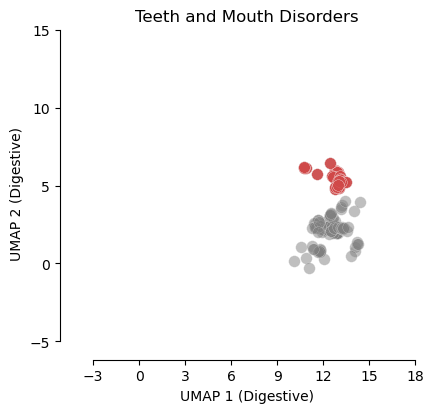

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker

# Create the figure and axis
fig, ax = plt.subplots(figsize=(4.75, 4.25))

# Scatter plot for all points
sns.scatterplot(
    data=local_embed_df, 
    x='UMAP_1', y='UMAP_2', 
    alpha=0.5, s=70, linewidth=0.25, edgecolor='white',
    color='gray', ax=ax
)

# Highlight points where category is 'teeth' or 'mouth'
highlight_data = local_embed_df[local_embed_df['category'].isin(['teeth', 'mouth'])]

sns.scatterplot(
    data=highlight_data, 
    x='UMAP_1', y='UMAP_2', 
    alpha=0.9, s=70, linewidth=0.25, edgecolor='white',
    color='#D04848', ax=ax
)

# Add labels and limits
plt.xlabel("UMAP 1 (Digestive)")
plt.ylabel("UMAP 2 (Digestive)")
plt.xlim(-5, 19)
plt.ylim(-6, 15)

# Set tick locators
loc = plticker.MultipleLocator(base=5.0)
ax.yaxis.set_major_locator(loc)

loc = plticker.MultipleLocator(base=3.0)
ax.xaxis.set_major_locator(loc)

# Remove top and right spines
sns.despine(offset=2, trim=True)

# Add title
plt.title("Teeth and Mouth Disorders")

# Show plot
plt.show()


In [73]:
import plotly.express as px

# Add a column to differentiate "teeth" and "mouth" categories from others
local_embed_df['highlight'] = local_embed_df['category'].isin(['teeth', 'mouth'])

# Create the scatter plot
fig = px.scatter(
    local_embed_df,
    x='UMAP_1',
    y='UMAP_2',
    color='highlight',  # Highlight "teeth" and "mouth" points
    hover_data={'phenotype': True, 'category': True},  # Show phenotype and category on hover
    opacity=0.7,
    title="Interactive Tooth and Mouth Disorders",
    color_discrete_map={True: '#D04848', False: 'gray'},  # Highlight "teeth" and "mouth" in red, others in gray
)

# Customize layout
fig.update_traces(
    marker=dict(size=7, line=dict(width=1, color='white')),  # Marker styling
)

fig.update_layout(
    xaxis_title="UMAP 1 (Digestive)",
    yaxis_title="UMAP 2 (Digestive)",
    template="plotly_white",
    height=700,
    width=900,
)

# Show the interactive plot
fig.show()


/var/folders/pq/qx5x9fj10pj3v7hdcsd6qzz40000gn/T/ipykernel_38629/3067653501.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



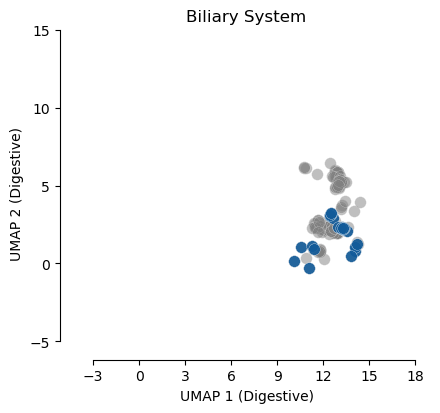

In [74]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# Create the figure and axis
fig, ax = plt.subplots(figsize=(4.75, 4.25))

# Scatter plot for all points (gray background points)
sns.scatterplot(
    data=local_embed_df,
    x='UMAP_1', y='UMAP_2', 
    alpha=0.5, s=70, linewidth=0.25, edgecolor='white',
    color='gray', ax=ax
)

# Filter data for 'Liver' and 'Biliary' categories
highlight_data = local_embed_df[local_embed_df['category'].isin(['Liver', 'Biliary'])]

# Highlight points for 'Liver' and 'Biliary' categories (blue points)
sns.scatterplot(
    data=highlight_data,
    x='UMAP_1', y='UMAP_2', 
    alpha=0.9, s=70, linewidth=0.25, edgecolor='white',
    color='#125B9A', ax=ax
)

# Add labels and adjust plot limits
plt.xlabel("UMAP 1 (Digestive)")
plt.ylabel("UMAP 2 (Digestive)")
plt.xlim(-5, 19)
plt.ylim(-6, 15)

# Set tick locators for axes
loc = plticker.MultipleLocator(base=5.0)
ax.yaxis.set_major_locator(loc)

loc = plticker.MultipleLocator(base=3.0)
ax.xaxis.set_major_locator(loc)

# Remove top and right spines for cleaner aesthetics
sns.despine(offset=2, trim=True)

# Add title
plt.title("Biliary System")

# Show the plot
plt.show()


In [75]:
import plotly.express as px

# Ensure the highlight column is based on the 'category'
local_embed_df['highlight'] = local_embed_df['category'].isin(['Liver', 'Biliary'])

# Create the interactive scatter plot
fig = px.scatter(
    local_embed_df,
    x='UMAP_1',
    y='UMAP_2',
    color='highlight',  # Highlight "Liver" and "Biliary" points
    hover_data={'phenotype': True, 'category': True},  # Show phenotype and category on hover
    opacity=0.7,
    title="Interactive Biliary Disorders",
    color_discrete_map={True: '#125B9A', False: 'gray'},  # Highlight "Liver/Biliary" in blue, others in gray
)

# Customize marker appearance
fig.update_traces(
    marker=dict(size=7, line=dict(width=1, color='white')),  # Set marker size and white border
)

# Customize layout
fig.update_layout(
    xaxis_title="UMAP 1 (Digestive)",
    yaxis_title="UMAP 2 (Digestive)",
    template="plotly_white",
    height=700,  # Set plot height
    width=900,   # Set plot width
)

# Show the interactive plot
fig.show()


/var/folders/pq/qx5x9fj10pj3v7hdcsd6qzz40000gn/T/ipykernel_38629/4213144935.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ellenbowen/opt/anaconda3/envs/ehail/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



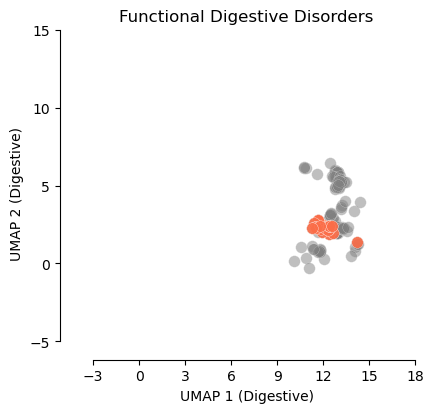

In [76]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

# Create the figure and axis
fig, ax = plt.subplots(figsize=(4.75, 4.25))

# Scatter plot for all points (gray background points)
sns.scatterplot(
    data=local_embed_df, 
    x='UMAP_1', y='UMAP_2', 
    alpha=0.5, s=70, linewidth=0.25, edgecolor='white',
    color='gray', ax=ax
)

# Filter data for 'Noninfective' category
highlight_data = local_embed_df[local_embed_df['category'] == 'Noninfective']

# Highlight points for 'Noninfective' category (orange-red points)
sns.scatterplot(
    data=highlight_data, 
    x='UMAP_1', y='UMAP_2', 
    alpha=0.9, s=70, linewidth=0.25, edgecolor='white',
    color='#FB6D48', ax=ax
)

# Adjust labels and plot limits
plt.xlabel("UMAP 1 (Digestive)")
plt.ylabel("UMAP 2 (Digestive)")
plt.xlim(-5, 19)
plt.ylim(-6, 15)

# Set tick locators for axes
loc = plticker.MultipleLocator(base=5.0)
ax.yaxis.set_major_locator(loc)

loc = plticker.MultipleLocator(base=3.0)
ax.xaxis.set_major_locator(loc)

# Remove top and right spines for cleaner aesthetics
sns.despine(offset=2, trim=True)

# Add title
plt.title("Functional Digestive Disorders")

# Show the plot
plt.show()


In [77]:
import plotly.express as px

# Add a column to differentiate "Noninfective" from other categories
local_embed_df['highlight'] = local_embed_df['category'] == 'Noninfective'

# Create the scatter plot
fig = px.scatter(
    local_embed_df,
    x='UMAP_1',
    y='UMAP_2',
    color='highlight',  # Highlight "Noninfective" points
    hover_data={'phenotype': True, 'category': True},  # Show phenotype and category on hover
    opacity=0.7,
    title="Interactive Functional Digestive Disorders",
    color_discrete_map={True: '#FB6D48', False: 'gray'},  # Highlight "Noninfective" in orange-red, others in gray
)

# Customize marker appearance
fig.update_traces(
    marker=dict(size=7, line=dict(width=1, color='white'))  # Set marker size and add a white border
)

# Customize layout
fig.update_layout(
    xaxis_title="UMAP 1 (Digestive)",
    yaxis_title="UMAP 2 (Digestive)",
    template="plotly_white",  # Clean white background
    height=700,  # Plot height
    width=900,   # Plot width
)

# Show the interactive plot
fig.show()


/var/folders/pq/qx5x9fj10pj3v7hdcsd6qzz40000gn/T/ipykernel_38629/2626435951.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

